VAE Model

Load,EDA

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, average_precision_score, precision_recall_curve, f1_score, roc_curve
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, LeakyReLU, Dropout, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew, kurtosis
from tensorflow import keras



In [2]:
# Load the datasets
df1 = pd.read_csv('updated_fraud_transactions.csv')
df2 = pd.read_csv('customer_dataset 1.csv')

# Merge the datasets
merged_df = pd.merge(df1, df2, left_on='Sender Account ID', right_on='Customer ID')

print(merged_df.head())
print(merged_df.info())

  Transaction ID            Timestamp  Sender Account ID Transaction Type  \
0         T00001  2023-08-14 08:37:07              10095         Transfer   
1         T00002  2023-12-04 12:54:11              10098         Transfer   
2         T00003  2023-07-09 23:16:11              10097           Credit   
3         T00004  2023-06-26 07:04:39              10039           Credit   
4         T00005  2023-09-28 02:40:56              10018            Debit   

  IN_OUT   Amount Recipient Bank  Fraud  Customer ID                    Name  \
0     In  4887.67          B0004      0        10095        Dilshan De Alwis   
1     In  2371.33         B00010      0        10098      Ruwan Samarasinghe   
2     In  4733.44          B0008      0        10097             Sarath Dias   
3     In  1544.12          B0005      0        10039            Nadeeka Dias   
4    Out  3978.04          B0004      0        10018  Chathura Hettiarachchi   

   Age    Location Gender Account Type  Device Count  
0

In [3]:
# Check class distribution
print(merged_df['Fraud'].value_counts(normalize=True))

Fraud
0    0.95147
1    0.04853
Name: proportion, dtype: float64


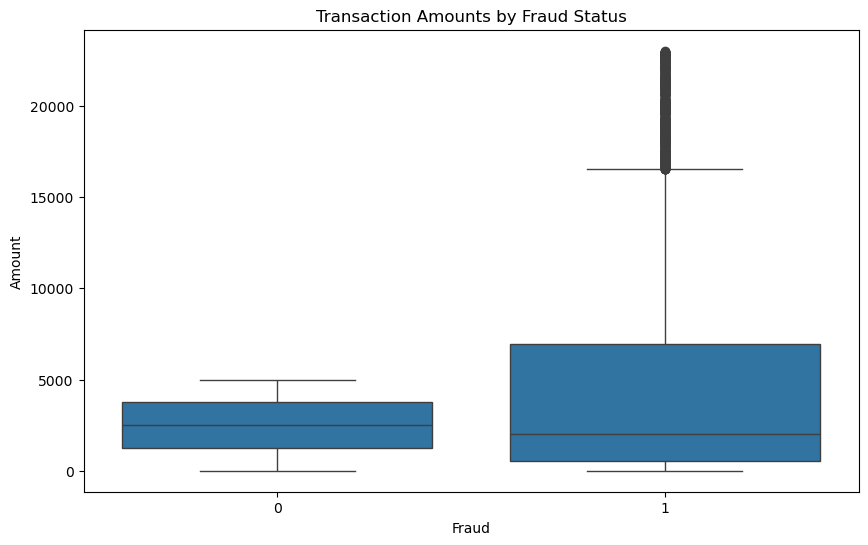

In [5]:
# Visualize transaction amounts by fraud status
plt.figure(figsize=(10, 6))
sns.boxplot(x='Fraud', y='Amount', data=merged_df)
plt.title('Transaction Amounts by Fraud Status')
plt.show()

In [6]:
# Outlier detection and treatment (example using IQR method for 'Amount')
Q1 = merged_df['Amount'].quantile(0.25)
Q3 = merged_df['Amount'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
merged_df['Amount'] = np.where(merged_df['Amount'] > upper_bound, upper_bound, merged_df['Amount'])
merged_df['Amount'] = np.where(merged_df['Amount'] < lower_bound, lower_bound, merged_df['Amount'])

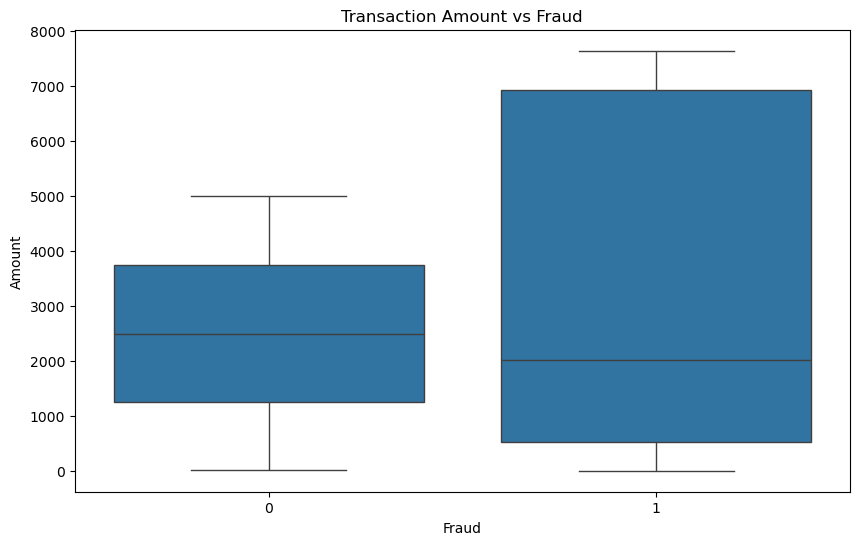

In [7]:
# Transaction Amount vs Fraud
plt.figure(figsize=(10, 6))
sns.boxplot(x='Fraud', y='Amount', data=merged_df)
plt.title('Transaction Amount vs Fraud')
plt.show()


In [8]:
# Analyze transaction types
fraud_by_type = merged_df.groupby('Transaction Type')['Fraud'].mean().sort_values(ascending=False)
print("Fraud rate by transaction type:")
print(fraud_by_type)

Fraud rate by transaction type:
Transaction Type
Transfer    0.087193
Debit       0.036431
Payment     0.036109
Credit      0.034439
Name: Fraud, dtype: float64


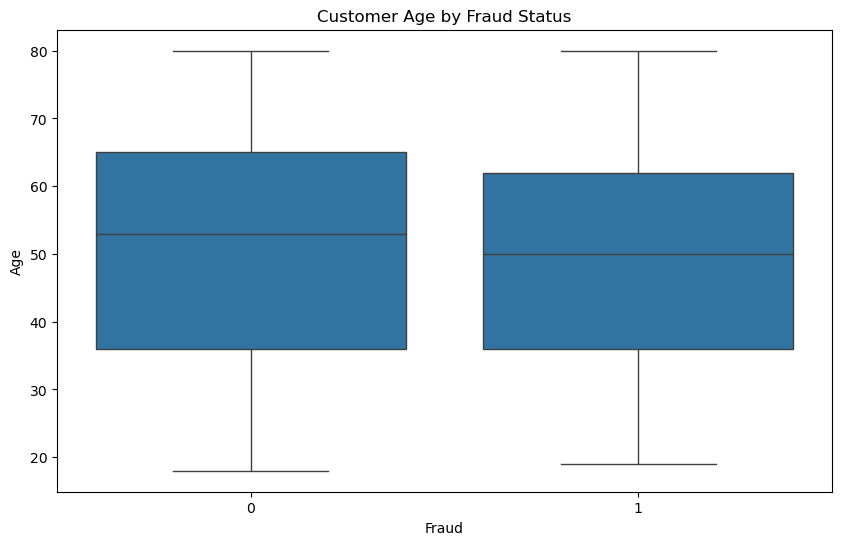

In [9]:
# Analyze customer age and fraud
plt.figure(figsize=(10, 6))
sns.boxplot(x='Fraud', y='Age', data=merged_df)
plt.title('Customer Age by Fraud Status')
plt.show()

Feature Engineering

In [10]:
# Convert timestamp to datetime
merged_df['Timestamp'] = pd.to_datetime(merged_df['Timestamp'])

# Extract time-based features
merged_df['Hour'] = merged_df['Timestamp'].dt.hour
merged_df['Day'] = merged_df['Timestamp'].dt.day
merged_df['Month'] = merged_df['Timestamp'].dt.month
merged_df['DayOfWeek'] = merged_df['Timestamp'].dt.dayofweek

# One-hot encode categorical variables
categorical_cols = ['Transaction Type', 'IN_OUT', 'Recipient Bank', 'Gender', 'Account Type', 'Location']
merged_df = pd.get_dummies(merged_df, columns=categorical_cols)

# Create age groups
merged_df['AgeGroup'] = pd.cut(merged_df['Age'], bins=[0, 30, 50, 70, 100], labels=['Young', 'Middle', 'Senior', 'Elderly'])
merged_df = pd.get_dummies(merged_df, columns=['AgeGroup'])

# Calculate transaction frequency for each customer
transaction_frequency = merged_df.groupby('Customer ID')['Transaction ID'].count().reset_index()
transaction_frequency.columns = ['Customer ID', 'TransactionFrequency']
merged_df = pd.merge(merged_df, transaction_frequency, on='Customer ID')

In [11]:
merged_df.head()


,Transaction ID,Timestamp,Sender Account ID,Amount,Fraud,Customer ID,Name,Age,Device Count,Hour,...,Location_Kandy,Location_Matara,Location_Negombo,Location_Ratnapura,Location_Trincomalee,AgeGroup_Young,AgeGroup_Middle,AgeGroup_Senior,AgeGroup_Elderly,TransactionFrequency
0,T00001,2023-08-14 08:37:07,10095,4887.67,0,10095,Dilshan De Alwis,59,10,8,...,False,False,False,False,False,False,False,True,False,986
1,T00002,2023-12-04 12:54:11,10098,2371.33,0,10098,Ruwan Samarasinghe,60,10,12,...,False,True,False,False,False,False,False,True,False,1008
2,T00003,2023-07-09 23:16:11,10097,4733.44,0,10097,Sarath Dias,64,8,23,...,False,False,False,False,False,False,False,True,False,969
3,T00004,2023-06-26 07:04:39,10039,1544.12,0,10039,Nadeeka Dias,60,1,7,...,True,False,False,False,False,False,False,True,False,986
4,T00005,2023-09-28 02:40:56,10018,3978.04,0,10018,Chathura Hettiarachchi,36,4,2,...,False,False,False,True,False,False,True,False,False,951


Feature Selection

In [12]:
# Scale numerical features
scaler = StandardScaler()
numerical_cols = ['Amount', 'Age', 'Device Count', 'TransactionFrequency']
merged_df[numerical_cols] = scaler.fit_transform(merged_df[numerical_cols])

In [13]:
# Prepare features and target
features = merged_df.drop(['Transaction ID', 'Timestamp', 'Customer ID', 'Name', 'Fraud'], axis=1)
target = merged_df['Fraud']


In [14]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)


In [15]:
print(f"Shape of training data: {X_train.shape}")
print(f"Shape of testing data: {X_test.shape}")

Shape of training data: (80000, 45)
Shape of testing data: (20000, 45)


Data Preprocessing

In [16]:
from imblearn.over_sampling import SMOTE

# Apply SMOTE to balance the classes
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

print(f"Shape of balanced training data: {X_train_balanced.shape}")
print(f"Distribution of target variable:\n{pd.Series(y_train_balanced).value_counts(normalize=True)}")

Shape of balanced training data: (152228, 45)
Distribution of target variable:
Fraud
0    0.5
1    0.5
Name: proportion, dtype: float64


In [17]:
from sklearn.feature_selection import SelectKBest, f_classif

# Select top K features based on ANOVA F-value
selector = SelectKBest(f_classif, k=20)
X_train_selected = selector.fit_transform(X_train_balanced, y_train_balanced)
X_test_selected = selector.transform(X_test)

# Get selected feature names
selected_features = X_train.columns[selector.get_support()].tolist()
print("Selected features:", selected_features)

print(f"Shape of selected training data: {X_train_selected.shape}")
print(f"Shape of selected testing data: {X_test_selected.shape}")

Selected features: ['Amount', 'Hour', 'DayOfWeek', 'Transaction Type_Transfer', 'IN_OUT_In', 'IN_OUT_Out', 'Recipient Bank_B0002', 'Recipient Bank_B0004', 'Recipient Bank_B0006', 'Gender_Female', 'Gender_Male', 'Gender_Other', 'Account Type_Fixed Deposit', 'Account Type_Savings', 'Location_Batticaloa', 'Location_Galle', 'Location_Jaffna', 'Location_Matara', 'Location_Trincomalee', 'AgeGroup_Middle']
Shape of selected training data: (152228, 20)
Shape of selected testing data: (20000, 20)


In [18]:
from sklearn.model_selection import train_test_split

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [19]:
# Create a pipeline for preprocessing and balancing
preprocessing = ImbPipeline([
    ('scaler', StandardScaler()),
    ('smote', SMOTE(sampling_strategy=0.5, random_state=42)),
    ('undersampler', RandomUnderSampler(sampling_strategy=0.8, random_state=42))
])

In [20]:
# Apply preprocessing to training data
X_train_balanced, y_train_balanced = preprocessing.fit_resample(X_train, y_train)


In [21]:
print("Original training set shape:", X_train.shape)
print("Balanced training set shape:", X_train_balanced.shape)
print("\nOriginal class distribution:")
print(y_train.value_counts(normalize=True))
print("\nBalanced class distribution:")
print(pd.Series(y_train_balanced).value_counts(normalize=True))

Original training set shape: (80000, 20)
Balanced training set shape: (85632, 20)

Original class distribution:
Fraud
0    0.951475
1    0.048525
Name: proportion, dtype: float64

Balanced class distribution:
Fraud
0    0.555552
1    0.444448
Name: proportion, dtype: float64


VAE model

In [19]:
import tensorflow as tf
from tensorflow import keras
import numpy as np

class Sampling(keras.layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

def build_encoder(input_shape, latent_dim):
    inputs = keras.Input(shape=input_shape)
    x = keras.layers.Dense(64, activation="relu")(inputs)
    x = keras.layers.Dense(32, activation="relu")(x)
    z_mean = keras.layers.Dense(latent_dim, name="z_mean")(x)
    z_log_var = keras.layers.Dense(latent_dim, name="z_log_var")(x)
    z = Sampling()([z_mean, z_log_var])
    return keras.Model(inputs, [z_mean, z_log_var, z], name="encoder")

def build_decoder(latent_dim, output_shape):
    inputs = keras.Input(shape=(latent_dim,))
    x = keras.layers.Dense(32, activation="relu")(inputs)
    x = keras.layers.Dense(64, activation="relu")(x)
    outputs = keras.layers.Dense(output_shape, activation="sigmoid")(x)
    return keras.Model(inputs, outputs, name="decoder")

class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction),
                    axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstruction = self.decoder(z)
        return reconstruction



In [20]:
# Set up the VAE
input_shape = X_train_selected.shape[1]
latent_dim = 10

encoder = build_encoder(input_shape, latent_dim)
decoder = build_decoder(latent_dim, input_shape)
vae = VAE(encoder, decoder)



In [21]:
# Compile the model
vae.compile(optimizer=keras.optimizers.Adam())



In [22]:
# Train the model
history = vae.fit(X_train_selected, X_train_selected, 
                  epochs=50, 
                  batch_size=32, 
                  validation_split=0.2)



Epoch 1/50


ValueError: in user code:

    File "/opt/anaconda3/envs/myenv/lib/python3.11/site-packages/keras/engine/training.py", line 1284, in train_function  *
        return step_function(self, iterator)
    File "/opt/anaconda3/envs/myenv/lib/python3.11/site-packages/keras/engine/training.py", line 1268, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/opt/anaconda3/envs/myenv/lib/python3.11/site-packages/keras/engine/training.py", line 1249, in run_step  **
        outputs = model.train_step(data)
    File "/var/folders/rb/_7_snk4x0cj_bx_rd6bjkhxw0000gn/T/ipykernel_49845/2099029544.py", line 48, in train_step
        z_mean, z_log_var, z = self.encoder(data)
    File "/opt/anaconda3/envs/myenv/lib/python3.11/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/opt/anaconda3/envs/myenv/lib/python3.11/site-packages/keras/engine/input_spec.py", line 219, in assert_input_compatibility
        raise ValueError(

    ValueError: Layer "encoder" expects 1 input(s), but it received 2 input tensors. Inputs received: [<tf.Tensor 'IteratorGetNext:0' shape=(None, 20) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(None, 20) dtype=float32>]


In [48]:
X = np.array(X)
y = np.array(y)

In [49]:
# Normalize X if it's not already normalized
X = (X - X.min()) / (X.max() - X.min())


In [50]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)


In [51]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)


X_train shape: (64000, 20)
y_train shape: (64000,)


In [52]:
best_params = hyperparameter_tuning(X_train, y_train, X_val, y_val)


2024-10-07 08:01:56.158739: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1, Loss: 0.6128
Epoch 11, Loss: 0.6110
Epoch 21, Loss: 0.6110


Epoch 1, Loss: 0.6145
Epoch 11, Loss: 0.6110
Epoch 21, Loss: 0.6110


Epoch 1, Loss: 0.6174
Epoch 11, Loss: 0.6110
Epoch 21, Loss: 0.6110


Epoch 1, Loss: 0.6130
Epoch 11, Loss: 0.6110
Epoch 21, Loss: 0.6110


Epoch 1, Loss: 0.6153
Epoch 11, Loss: 0.6110
Epoch 21, Loss: 0.6110


Epoch 1, Loss: 0.6176
Epoch 11, Loss: 0.6110
Epoch 21, Loss: 0.6110


Epoch 1, Loss: 0.6127
Epoch 11, Loss: 0.6110
Epoch 21, Loss: 0.6110


Epoch 1, Loss: 0.6147
Epoch 11, Loss: 0.6110
Epoch 21, Loss: 0.6110


Epoch 1, Loss: 0.6194
Epoch 11, Loss: 0.6110
Epoch 21, Loss: 0.6110


Epoch 1, Loss: 0.6133
Epoch 11, Loss: 0.6110
Epoch 21, Loss: 0.6110


Epoch 1, Loss: 0.6158
Epoch 11, Loss: 0.6110
Epoch 21, Loss: 0.6110


Epoch 1, Loss: 0.6192
Epoch 11, Loss: 0.6110
Epoch 21, Loss: 0.6110


Epoch 1, Loss: 0.6130
Epoch 11, Loss: 0.6110
Epoch 21, Loss: 0.6110


Epoch 1, Loss: 0.6153
Epoch 11, Loss: 0.6110
Epoch 21, Loss: 0.6110


Epoch 1, Loss: 0.6183
Epoch 11, Loss: 0.6110
Epoch 21, Loss: 0.6110


Epoch 1, Loss: 0.6128
Epoch 11, Loss: 0.6110
Epoch 21, Loss: 0.6110


Epoch 1, Loss: 0.6151
Epoch 11, Loss: 0.6110
Epoch 21, Loss: 0.6110


Epoch 1, Loss: 0.6190
Epoch 11, Loss: 0.6110
Epoch 21, Loss: 0.6110


Epoch 1, Loss: 0.6133
Epoch 11, Loss: 0.6110
Epoch 21, Loss: 0.6110


Epoch 1, Loss: 0.6155
Epoch 11, Loss: 0.6110
Epoch 21, Loss: 0.6110


Epoch 1, Loss: 0.6183
Epoch 11, Loss: 0.6110
Epoch 21, Loss: 0.6110


Epoch 1, Loss: 0.6134
Epoch 11, Loss: 0.6110
Epoch 21, Loss: 0.6110


Epoch 1, Loss: 0.6157
Epoch 11, Loss: 0.6110
Epoch 21, Loss: 0.6110


Epoch 1, Loss: 0.6180
Epoch 11, Loss: 0.6110
Epoch 21, Loss: 0.6110


Epoch 1, Loss: 0.6137
Epoch 11, Loss: 0.6110
Epoch 21, Loss: 0.6110


Epoch 1, Loss: 0.6146
Epoch 11, Loss: 0.6110
Epoch 21, Loss: 0.6110


Epoch 1, Loss: 0.6195
Epoch 11, Loss: 0.6110
Epoch 21, Loss: 0.6110
Best Hyperparameters: {'latent_dim': 8, 'learning_rate': 0.0001, 'batch_size': 32}
Best AUC-ROC Score: 0.6050704011353013


In [60]:
# Cell 9: Train the final model with best hyperparameters
final_model = VAE(X_train.shape[1], best_params['latent_dim'])
train_vae(final_model, X_train, epochs=50, batch_size=best_params['batch_size'])


Epoch 1, Loss: 0.6133
Epoch 11, Loss: 0.6110
Epoch 21, Loss: 0.6110
Epoch 31, Loss: 0.6110
Epoch 41, Loss: 0.6110


AUC-ROC: 0.5000
Average Precision Score: 0.0473


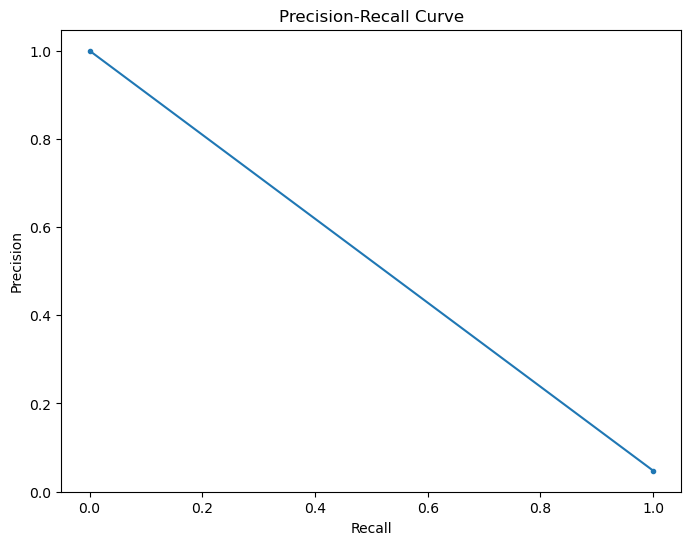


Classification Report:
              precision    recall  f1-score   support

      Normal       0.00      0.00      0.00     19054
       Fraud       0.05      1.00      0.09       946

    accuracy                           0.05     20000
   macro avg       0.02      0.50      0.05     20000
weighted avg       0.00      0.05      0.00     20000



/opt/anaconda3/envs/myenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/myenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/myenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [61]:
evaluate_vae(final_model, X_test, y_test)
